# 7. 문서 군집화 소개와 실습 - Opinion Review 데이터 세트

문서 군집화
- 비슷한 텍스트 구성의 문서를 군집화하는 것
- 학습 데이터 세트가 피료없는 비지도학습 기반으로 동작

## Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import pandas as pd
import glob, os

In [40]:
path = r'/content/drive/MyDrive/Colab Notebooks/topics'
# path로 지정한 디렉터리 밑에 있는 모든 .data파일의 파일명을 리스트로 취합
all_files=glob.glob(os.path.join(path, '*.data'))
filename_list=[]
opinion_text=[]

In [41]:
# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text_list로 취합
for file_ in all_files:
  # 개별 파일 읽어서 DataFrame으로 생성
  df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')

  # 절대 경로로 주어진 파일명을 가공, 리눅스에서 수행할 때는 ||를 /로 변경
  # 맨 마지막 .data 확장자도 제거
  filename_=file_.split('/')[-1]
  filename=filename_.split('.')[0]

  # 파일명 list와 파일 내용 list에 파일명과 파일내용 추가
  filename_list.append(filename)
  opinion_text.append(df.to_string())

# 파일명 list와 파일내용 ㅣist객체를 DataFrame으로 생성
document_df=pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()


,filename,opinion_text
0,battery-life_ipod_nano_8gb,...
1,directions_garmin_nuvi_255W_gps,...
2,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...
3,satellite_garmin_nuvi_255W_gps,...
4,speed_garmin_nuvi_255W_gps,...


TF-IDF 형태로 문서를 피처 벡터화하기
- LemNormalize()함수 이용
- min_df, max_df 범위 설정해서 피처 개수 제한
- TfidVectorizer의 fit_transform()의 인자로 document_Df DataFrame의 opinion_text 칼럼을 입력하면 개별 문서 텍스트에 대해 TF-IDF 변환된 피처 벡터화된 행렬을 얻을 수 있음

In [42]:
# TF-IDF 형태로 피처 벡터화.

# LemNormalize 함수 불러오기

from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)

    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)

    # 단어 원형 추출
    return LemTokens(word_tokens)

In [43]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
# 개별 문서 텍스트에 대해 TF-IDF 변환된 피처 벡터화된 행렬 구하기

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                           ngram_range=(1,2), min_df=0.05, max_df=0.85)

feature_vect=tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [45]:
# KMeans 수행한 후에 군집의 LAbel 값과 중심별로 할당된 데이터 세트의 좌표 값 구하기

from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster=KMeans(n_clusters=5, max_iter=100000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
document_df['cluster_label']=cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,2
1,directions_garmin_nuvi_255W_gps,...,0
2,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,2
3,satellite_garmin_nuvi_255W_gps,...,0
4,speed_garmin_nuvi_255W_gps,...,0


In [47]:
# sort_values(by=정렬하려는 칼럼명)

document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
13,accuracy_garmin_nuvi_255W_gps,...,0
1,directions_garmin_nuvi_255W_gps,...,0
8,display_garmin_nuvi_255W_gps,...,0
3,satellite_garmin_nuvi_255W_gps,...,0
4,speed_garmin_nuvi_255W_gps,...,0
17,updates_garmin_nuvi_255W_gps,...,0
7,voice_garmin_nuvi_255W_gps,...,0


In [48]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
45,bathroom_bestwestern_hotel_sfo,...,1
34,food_holiday_inn_london,...,1
33,food_swissotel_chicago,...,1
44,free_bestwestern_hotel_sfo,...,1
46,location_bestwestern_hotel_sfo,...,1
32,location_holiday_inn_london,...,1
40,parking_bestwestern_hotel_sfo,...,1
27,price_amazon_kindle,...,1
35,price_holiday_inn_london,...,1
20,room_holiday_inn_london,...,1


In [49]:

document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
26,battery-life_amazon_kindle,...,2
0,battery-life_ipod_nano_8gb,...,2
15,battery-life_netbook_1005ha,...,2
22,performance_netbook_1005ha,...,2
2,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,2
10,video_ipod_nano_8gb,...,2


In [50]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
41,comfort_honda_accord_2008,...,3
21,comfort_toyota_camry_2007,...,3
28,gas_mileage_toyota_camry_2007,...,3
37,interior_honda_accord_2008,...,3
18,interior_toyota_camry_2007,...,3
39,mileage_honda_accord_2008,...,3
49,performance_honda_accord_2008,...,3
43,quality_toyota_camry_2007,...,3
42,seats_honda_accord_2008,...,3
48,transmission_toyota_camry_2007,...,3


In [51]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
36,buttons_amazon_kindle,...,4
19,eyesight-issues_amazon_kindle,...,4
12,features_windows7,...,4
31,fonts_amazon_kindle,...,4
14,keyboard_netbook_1005ha,...,4
30,navigation_amazon_kindle,...,4
16,screen_garmin_nuvi_255W_gps,...,4
9,screen_ipod_nano_8gb,...,4
5,screen_netbook_1005ha,...,4
6,size_asus_netbook_1005ha,...,4


군집화 결과 군집 개수가 약간 많게 설정돼 있어서 세분화되어 군집화된 경향이 있음

-> 중심개수 낮추기

In [52]:
# 중심개수를 5 -> 3으로 낮추고 세 그룹 군집화 결과 보면 ...

from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster=KMeans(n_clusters=3, max_iter=100000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label']=cluster_label
document_df.sort_values(by='cluster_label')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,filename,opinion_text,cluster_label
39,mileage_honda_accord_2008,...,0
48,transmission_toyota_camry_2007,...,0
21,comfort_toyota_camry_2007,...,0
49,performance_honda_accord_2008,...,0
18,interior_toyota_camry_2007,...,0
28,gas_mileage_toyota_camry_2007,...,0
42,seats_honda_accord_2008,...,0
41,comfort_honda_accord_2008,...,0
37,interior_honda_accord_2008,...,0
43,quality_toyota_camry_2007,...,0


## 군집별 핵심 단어 추출하기

clusters_centers_
- 각 군집을 구성하는 단어 피처가 군집의 중심을 기준으로 얼마나 가깝게 위치해있는지 알려줌
- 행 : 개별군집 / 열 : 개별 피처
- 예) clusters_centers[0,1] : 0번 군집에서 두번째 피처의 위치 값

In [53]:
# 앞에서 만든 km_cluster에서 cluster_centers_속성 가져와서 값 확인해보기

cluster_centers=km_cluster.cluster_centers_
print('cluster centers shape: ', cluster_centers.shape)
print(cluster_centers)

cluster centers shape:  (3, 4611)
[[0.         0.00092551 0.         ... 0.         0.         0.        ]
 [0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]]


ndarray의 argsort()[:,::-1] - cluster_centers 배열 내 값이 큰 순으로 정렬된 위치 인덱스 값 반환

In [54]:
# cluster_centers_ 속성값 이용해서 각 군집별 핵심단어 찾아보기

# get_cluster_details() 함수 생성

# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함.
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}

    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]

    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화.
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num

        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함.
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]

        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames

    return cluster_details

In [55]:
# print_cluster_details 함수 생성

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [56]:
feature_names=tfidf_vect.get_feature_names_out()

cluster_details=get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                    feature_names=feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['interior_toyota_camry_2007', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord_2008', 'mileage_honda_accord_2008', 'comfort_honda_accord_2008', 'seats_honda_accord_2008']
####### Cluster 1
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_ipod_nano_8gb', 'directions_garmin_nuvi_255W_gps', 'sound_ipod_nano_8gb', 'satellite_garmin_nuvi_255W_gps', 'speed_garmin_nuvi_255W_gps', 'screen_netbook_1005ha', 'size_asus_netbook_1005ha']
####### Cluster 2
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['room_holiday_inn_london', 'staff_swissotel_chicago', 'rooms_swissotel_chicago', 'service_holiday_inn_london', 'service_swi

# 10. 텍스트 분석 실습 : 캐글 Mercari Price Suggestion Challenge
일본 대형 온라인 쇼핑몰 제품에 대한 가격예측
- 예측 타깃값 : price (피처로 예측하기)

## 데이터 전처리

In [65]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('/content/sample_data/train.tsv', sep='\t', error_bad_lines=False)
print(mercari_df.shape)
mercari_df.head(3)

<ipython-input-65-de940b74ada7>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  mercari_df=pd.read_csv('/content/sample_data/train.tsv', sep='\t', error_bad_lines=False)
Skipping line 23193: expected 8 fields, saw 9
Skipping line 27865: expected 8 fields, saw 10
Skipping line 36995: expected 8 fields, saw 12
Skipping line 55578: expected 8 fields, saw 11

Skipping line 69495: expected 8 fields, saw 12
Skipping line 88135: expected 8 fields, saw 14
Skipping line 106708: expected 8 fields, saw 15
Skipping line 129916: expected 8 fields, saw 12

Skipping line 153112: expected 8 fields, saw 15
Skipping line 171521: expected 8 fields, saw 14

Skipping line 199337: expected 8 fields, saw 14
Skipping line 213182: expected 8 fields, saw 9
Skipping line 217786: expected 8 fields, saw 14
Skipping line 231485: expected 8 fields, saw 15
Skipping line 259340: expected 8 fields, saw 14

Skipping line 2777

(462069, 8)


<ipython-input-65-de940b74ada7>:6: DtypeWarning: Columns (0,2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  mercari_df=pd.read_csv('/content/sample_data/train.tsv', sep='\t', error_bad_lines=False)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...


In [66]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462069 entries, 0 to 462068
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           462069 non-null  object 
 1   name               462065 non-null  object 
 2   item_condition_id  462058 non-null  object 
 3   category_name      460076 non-null  object 
 4   brand_name         264579 non-null  object 
 5   price              462050 non-null  float64
 6   shipping           462050 non-null  object 
 7   item_description   462049 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.2+ MB
None


- brand_name 칼럼 : 많은 null값 가짐

<ipython-input-67-3730732f36c3>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

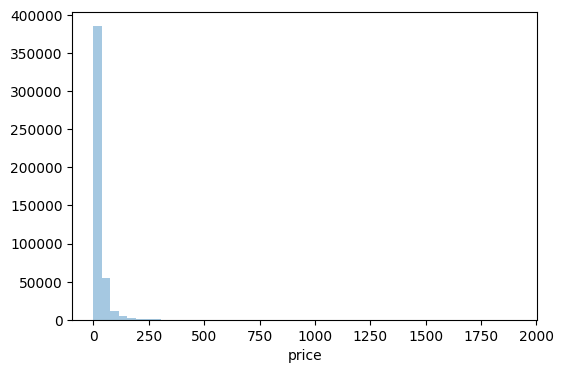

In [67]:
# 타겟값인 price 칼럼의 데이터 분포도 보기

# 왜곡된 값    (왜곡되어 있으면 보통 로그변활할 때 정규분포 형태 지님)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.distplot(y_train_df, kde=False)

<ipython-input-68-59f026499ece>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

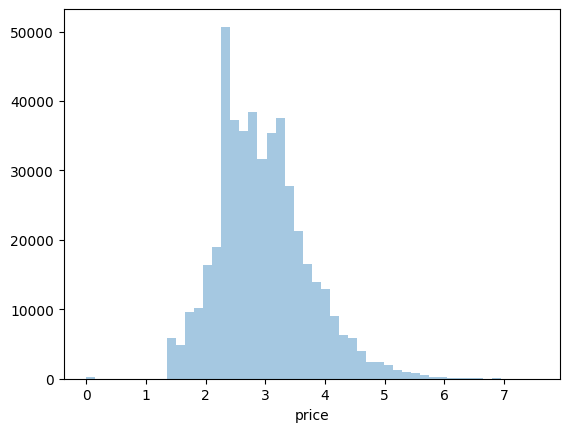

In [68]:
# price 칼럼을 로그값으로 변환한 뒤 분포도 보기 -> 비교적 정규분포에 가까운 개형

import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [69]:
# 데이터 세트의 price 칼럼을 원래값에서 로그변환 값으로 변경하기

mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [70]:
# 다른 피처 값

print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0.0          219478
1.0          177039
0             36210
1             29322
Brand new         1
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1                                       170926
3                                       115596
2                                       100888
1                                        28223
3                                        19063
2                                        16772
4                                         8421
4                                         1379
5                                          693
5                                           95
105.0                                        1
Women/Women's Accessories/Sunglasses         1
Name: item_condition_id, dtype: int64


In [71]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

25935

In [ ]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

In [ ]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

In [ ]:
# Null 값 일관적으로 Other_Null 변경

mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other_Null')

# 피처 인코딩과 피처 벡터화

피처 벡터화의 경우
- 짧은 텍스트 : count기반의 벡터화
- 긴 텍스트 : TF-IDF 기반의 벡터화

In [ ]:
# brand_name 칼럼 -> 별도 피처 벡터화 필요 없음. 원핫 인코딩 변환할것임

print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

In [ ]:
# name
print('name의 유형 건수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

In [ ]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description의 평균 문자열 크기  :', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

In [ ]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec=CountVectorizer()
X_name=cnt_vec.fit_transform(mercari_df.name)

# item_descriotion에 대한 피처 벡터화 변환
tfidf_descp=TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp=tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

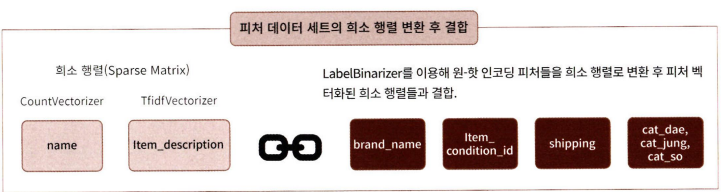

In [ ]:
# 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [75]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

NameError: ignored

In [ ]:
# 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환한 데이터 세트를 hstack()을 이용해 모두 결합

from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name, X_descp, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()

## 릿지 회귀 모델 구축 및 평가

RMSLE

In [77]:
# RMSLE

def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [78]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)

    del X , X_train , X_test , y_train
    gc.collect()

    return preds , y_test

In [ ]:
# Item_description 속성의 피처 벡터화게 포함되지 않았을때와 포함됐을 때의 예측 성능 비교

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

LightGBM 회귀

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

앙상블 방식으로 예측 성능이 개선됨